<img src = "banner.jpeg" />

## AI FASHION DISCRIMINATOR

    AI Fashion Discriminator is a tool based on Convolutional Neural Networks that analyzes your ouftit be it as a picture you feed it manually or as a picture taken directly from your webcam.
    
    It helps you make better fashion decisions before going outside!

## **IMPORTS**

In [4]:

#!pip install imageio
#!pip install opencv-python
#!pip install matplotlib
#!pip install seaborn
import matplotlib.pyplot as plt
import numpy as np
import math
import cv2
import seaborn as sns
import time
import scipy as sp

sns.set_theme()

## **Importing clean images**

In [6]:

def clean_background(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    thresh1 = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]

    hh, ww = thresh1.shape

    # make bottom 2 rows black where they are white the full width of the image
    thresh1[hh-3:hh, 0:ww] = 0

    # get bounds of white pixels
    white = np.where(thresh1==255)
    xmin, ymin, xmax, ymax = np.min(white[1]), np.min(white[0]), np.max(white[1]), np.max(white[0])
    #print(xmin,xmax,ymin,ymax)

    # crop the image at the bounds adding back the two blackened rows at the bottom
    crop = img[ymin:ymax+3, xmin:xmax]

    crop = cv2.resize(crop, (40, 80))

    return crop

import glob

#Path for Windows usage
#path = "C:/Users/juanp/Documents/AI Fashion Discriminator/Dataset"

path="/home/ch0ry/Documents/AI Fashion Discriminator/Dataset"

good_img = [clean_background(cv2.resize(cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB), (350, 700))) for file in glob.glob(path + '/Good/NoBg/*.png')]

bad_img = [clean_background(cv2.resize(cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB), (350, 700))) for file in glob.glob(path + '/Bad/NoBg/*.png')]


## **THIS BLOCK IS USED TO REMOVE BACKGROUND FROM IMAGES, ONLY USE WHEN NEW IMAGES ARE ADDED**

In [ ]:

#!pip install --ignore-installed --pre onnxruntime-gpu --user
#!pip install rembg[gpu] --user
from rembg import remove

seqG = 0
seqB = 0


for input in good_img:
    output_path_good = path+"/Good/NoBg/GoodClean{}.png".format(seqG)

    output = remove(input)
    cv2.imwrite(output_path_good, output)
    seqG += 1

for input in bad_img:

    output_path_bad = path+"/Bad/NoBg/BadClean{}.png".format(seqB)

    #input = iio.imread(file)
    output = remove(input)
    cv2.imwrite(output_path_bad, output)
    seqB += 1

## **Good outfit examples**

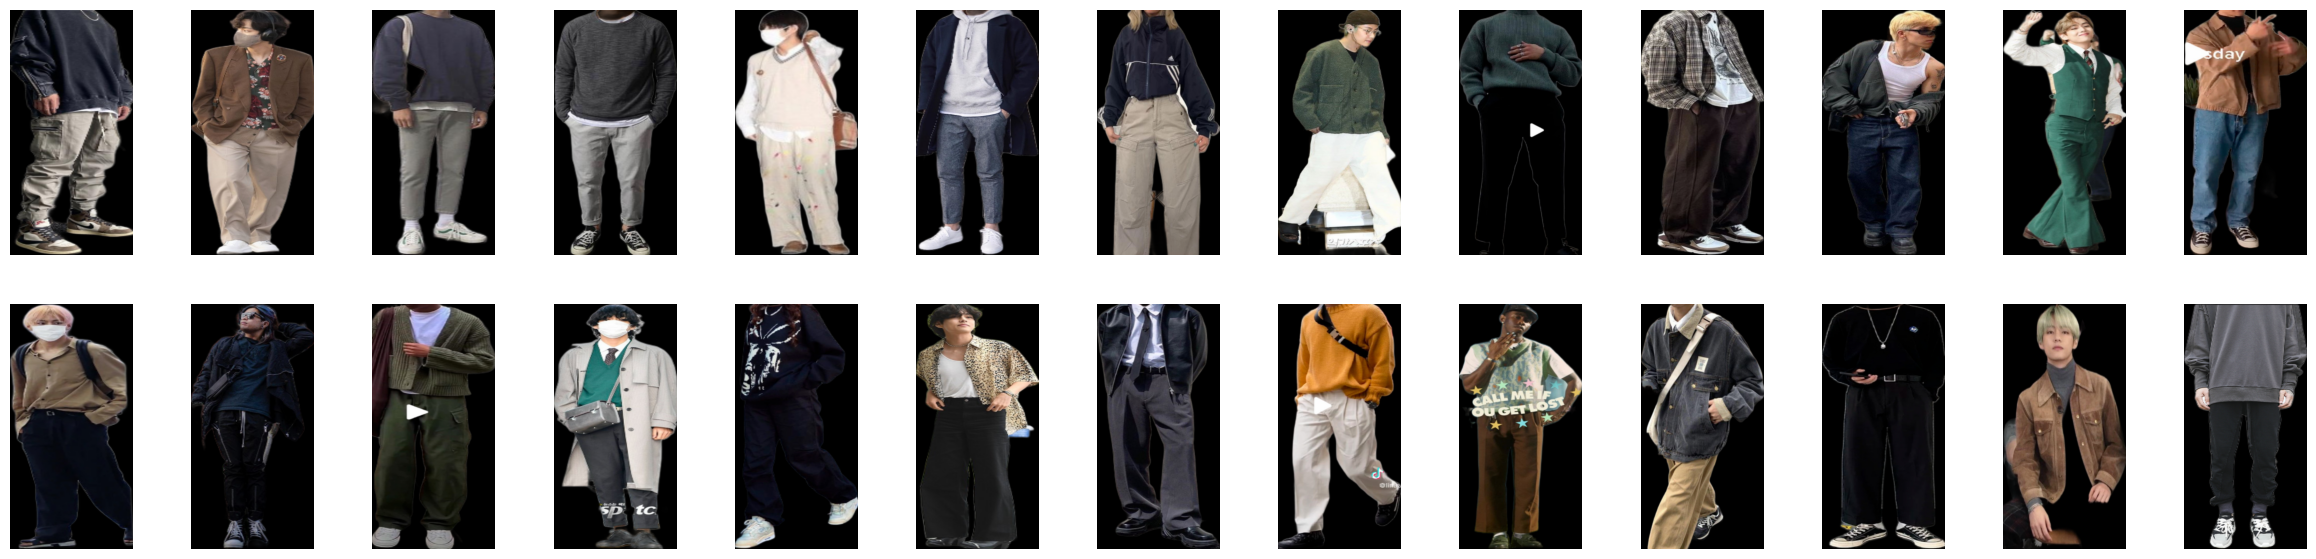

In [3]:

fig = plt.figure(figsize = (30, 7))

rows = 2
columns = int(math.floor(len(good_img)/2))

for i in range(rows*columns):
  
  fig.add_subplot(rows, columns, i+1)
  plt.imshow(good_img[i])
  plt.axis('off')
  #plt.title(i+1)


plt.show()

## **Bad outfit examples**

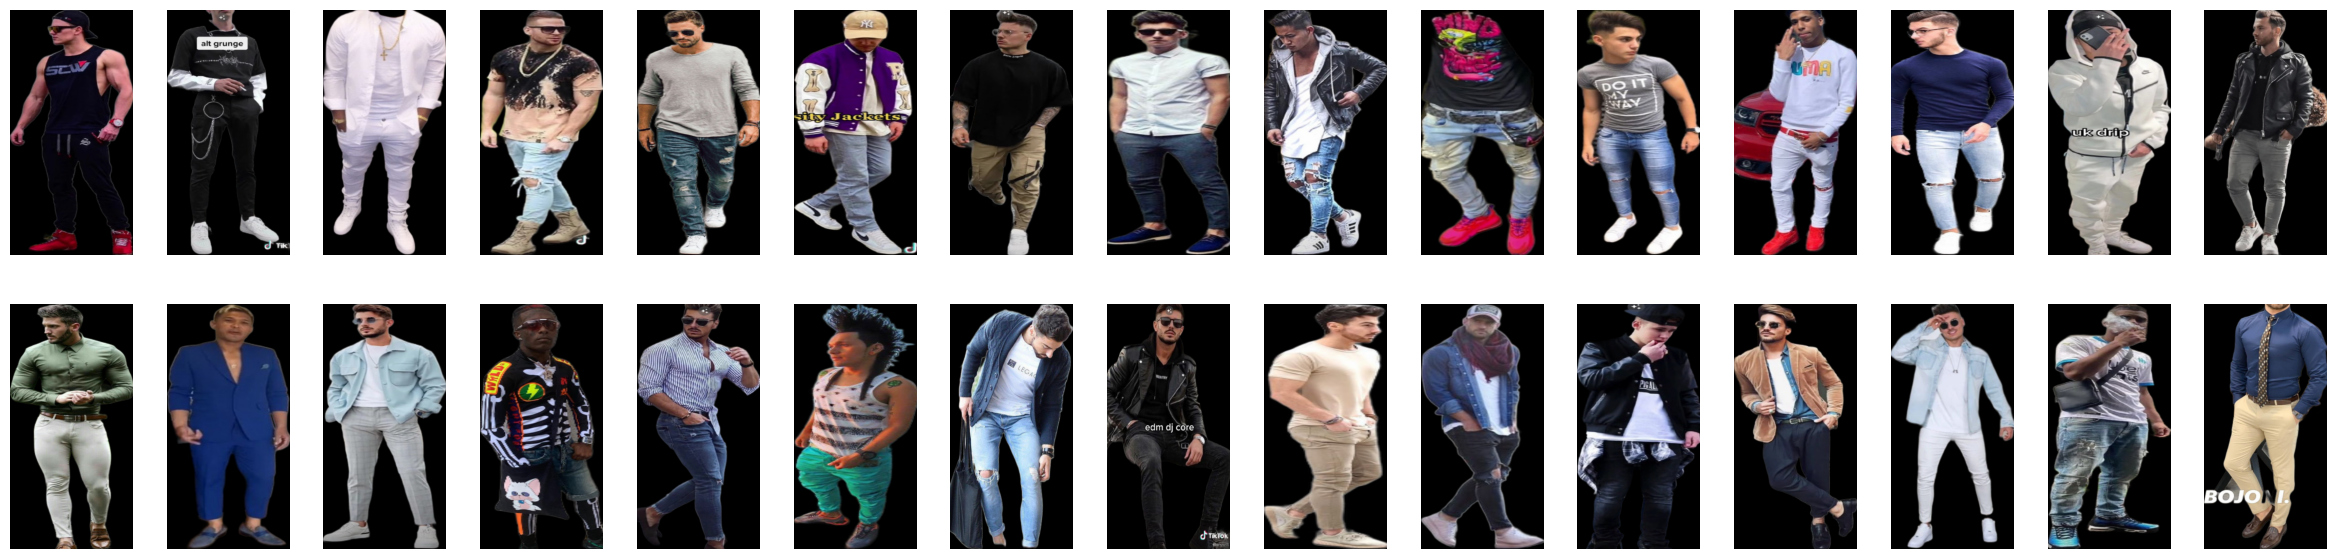

In [14]:
fig = plt.figure(figsize = (30, 7))

rows = 2
columns = int(math.floor(len(bad_img)/2))

for i in range(rows*columns):
  
  fig.add_subplot(rows, columns, i+1)
  plt.imshow(bad_img[i])
  plt.axis('off')
  #plt.title(i+1)


plt.show()

## **Classifier implementation**

### Preparing data

In [7]:
#@title **Preparing data**
#!pip install scikit-learn
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import *

#Se crean los arrays para ser usados en clasificacion

X = list()
y = list()

for img in good_img:
  X.append(np.asarray(img))
  y.append(1)

for img in bad_img:
  X.append(np.asarray(img))
  y.append(0)

#Se convierten las listas en arrays de NumPy, para reducirlos a arreglos bidimensionales que lee el estimador

X = np.asarray(X)



#X = np.reshape(X,(X.shape[0], (X.shape[1]*X.shape[2])))  40


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


## Code used for designing and training the CNN

In [8]:
#!pip install tensorflow
#!pip install keras
#!pip install protobuf==3.19.4 --user

import tensorflow as tf
from tensorflow.keras import datasets, layers, models


model = models.Sequential()
model.add(layers.Conv2D(256, (4, 4), activation='relu', input_shape=X_train[0].shape))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (4, 4), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (4, 4), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1))

model.summary()

2023-02-13 20:21:49.301499: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-13 20:21:50.023933: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ch0ry/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:
2023-02-13 20:21:50.023954: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-13 20:21:51.074062: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dler

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 77, 37, 256)       12544     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 38, 18, 256)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 35, 15, 128)       524416    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 17, 7, 128)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 4, 64)         131136    
                                                                 
 flatten (Flatten)           (None, 3584)              0

2023-02-13 20:21:51.942938: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ch0ry/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:
2023-02-13 20:21:51.943134: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-13 20:21:51.943149: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ch0ry-pc): /proc/driver/nvidia/version does not exist
2023-02-13 20:21:51.943750: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [ ]:
model.compile(optimizer='adadelta',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

y_test = np.asarray(y_test)

y_train = np.asarray(y_train)
history = model.fit(X_train, y_train, epochs=15,
                    validation_data=(X_test, y_test))

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

<img src = "accuracy_graph.png" />

## Loading the trained model for usage

In [10]:
import tensorflow as tf
import tensorflow.keras as keras
model = keras.models.load_model('model2.h5')

### Background removal, resizing and color correcting for prediction

In [12]:
from rembg import remove
def pred_img(img):
    img = clean_background(cv2.resize(cv2.cvtColor(remove(img), cv2.COLOR_BGR2RGB), (350, 700)))
    plt.imshow(img)
    plt.axis("off")

    answer = model.predict(np.asarray([img]))[0][0]
    print(answer)
    if answer >= 0.5:
      text = "Good"
    else:
      text = "Bad"

    return text

### Predicting images selected manually

1/1 [==============================] - 0s 21ms/step
2.4601645


'Good'

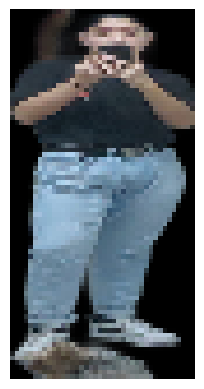

In [18]:
source = path+"/Test/T3.jpeg"

test = cv2.imread(source)
pred_img(test)

### Using webcam for taking pictures and predicting in real time

In [1]:
cap = cv2.VideoCapture(0)
cap.set(3,1920) # adjust width
cap.set(4,720) # adjust height
font = cv2.FONT_HERSHEY_SIMPLEX
img_counter = 0

wait = False
show = False

while True:
    success, img = cap.read()
    #cv2.rectangle(img, (300, 20), (1000, 700), (0, 255, 0), 5)
     # This will open an independent window
    cv2.imshow("Webcam", img)
    if show:
        cv2.putText(img, 
                text, 
                (400, 600), 
                font, 1, 
                (0, 255, 255), 
                2, 
                cv2.LINE_4)
        cv2.imshow("Webcam", img)
   
    k = cv2.waitKey(1)
    if k%256 == 32:
        t1 = time.time()
        wait = True
        show = False
        
    if  wait and time.time() - t1 > 2:
            img_name = "opencv_frame_{}.png".format(img_counter)
            cv2.imwrite(img_name, img)
            print("{} written!".format(img_name))
            img_counter += 1
            ss = cv2.imread(img_name)
            text = pred_img(ss)
            
            show = True
            wait = False
    if k%256 == 27: # quit when 'esc' is pressed
        cap.release()
        break
        
cv2.destroyAllWindows() 
cv2.waitKey(1)

NameError: name 'cv2' is not defined